In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from pysal.lib import weights
from libpysal import weights
from spreg import OLS, GM_Lag


In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n = 100  # Number of observations
rho = 0.5  # Spatial autoregressive parameter
true_beta = 0.5  # True coefficient of X

# Generate coordinates for a 10x10 grid
coords = np.array([(i // 10, i % 10) for i in range(n)])  # 10x10 grid

# Create a spatial weight matrix manually for a 10x10 grid
def create_weight_matrix(n):
    W = np.zeros((n, n))
    for i in range(n):
        if i % 10 != 0:  # left neighbor
            W[i, i - 1] = 1
        if i % 10 != 9:  # right neighbor
            W[i, i + 1] = 1
        if i >= 10:  # upper neighbor
            W[i, i - 10] = 1
        if i < 90:  # lower neighbor
            W[i, i + 10] = 1
    return W

W_matrix = create_weight_matrix(n)
W_matrix = W_matrix / W_matrix.sum(axis=1, keepdims=True)
W = csr_matrix(W_matrix)  # Convert to sparse matrix

# Number of simulations
n_simulations = 100

# Store results
ols_estimates = []

for _ in range(n_simulations):

    # Generate independent variable
    X = np.random.normal(size=n)

    # Generate spatially lagged variable
    W_X = W.dot(X)  # Spatial lag of X

    # Generate dependent variable with some noise
    epsilon = np.random.normal(size=n)
    Y = 1 + rho * W_X + 0.5 * X + epsilon  # FAR model

    # Create a DataFrame
    data = pd.DataFrame({'Y': Y, 'X': X, 'W_X': W_X})

**Interpretation**
Weight Matrix: A spatial weight matrix 𝑊 was created for a 10x10 grid. Each observation represents a cell in this grid, and neighbors are defined as the four adjacent cells (left, right, above, below).
The dataset simulates spatially dependent data where 𝑌 is influenced by its neighbors’ 𝑋 values (through 𝑊𝑋) and its own 𝑋 value.

In [6]:
import statsmodels.api as sm

# Fit OLS model
X_ols = sm.add_constant(data['X'])  # Add constant term
ols_model = sm.OLS(data['Y'], X_ols).fit()

# Print OLS results
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     26.87
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           1.17e-06
Time:                        12:55:44   Log-Likelihood:                -143.69
No. Observations:                 100   AIC:                             291.4
Df Residuals:                      98   BIC:                             296.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9582      0.103      9.277      0.0

**Interpretation**: OLS captures the direct relationship between 𝑋 and 𝑌, ignoring spatial dependence. The results are slightly biased but close to the true value.

In [10]:
from pysal.model import spreg
from spreg import GM_Lag

n_simulations = 100
ols_estimates = []
far_estimates = []

for _ in range(n_simulations):
    X = np.random.normal(size=n)
    epsilon = np.random.normal(size=n)
    W_X = W.dot(X)
    Y = 1 + rho * W_X + 0.5 * X + epsilon

    # OLS
    X_ols = sm.add_constant(X)
    ols_model = sm.OLS(Y, X_ols).fit()
    ols_estimates.append(ols_model.params[1])  # Coefficient of X

    # FAR
    far_model = spreg.OLS(data['Y'], data[['X']], w=W, name_y='Y', name_x=['X'], name_w='W')
    far_model2 = GM_Lag(Y, X.reshape(-1, 1), w=W, name_y='Y', name_x=['X'])
    far_estimates.append(far_model.betas[1][0])  # Coefficient of X

print(f"Mean OLS Estimate: {np.mean(ols_estimates):.4f}, Bias: {np.mean(ols_estimates) - 0.5:.4f}")
print(f"Mean FAR Estimate: {np.mean(far_estimates):.4f}, Bias: {np.mean(far_estimates) - 0.5:.4f}")
print(far_model.summary)
print(far_model2.summary)


Mean OLS Estimate: 0.5100, Bias: 0.0100
Mean FAR Estimate: 0.5085, Bias: 0.0085
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :           W
Dependent Variable  :           Y                Number of Observations:         100
Mean dependent var  :      1.0075                Number of Variables   :           2
S.D. dependent var  :      1.1551                Degrees of Freedom    :          98
R-squared           :      0.2152
Adjusted R-squared  :      0.2072
Sum squared residual:     103.667                F-statistic           :     26.8700
Sigma-square        :       1.058                Prob(F-statistic)     :   1.169e-06
S.E. of regression  :       1.029                Log likelihood        :    -143.694
Sigma-square ML     :       1.037                Akaike info criterion :     291.389
S.E of regression ML:      1.0182                Schwarz criterion

**Interpretation**: FAR provides a biased estimate for 𝑋, potentially due to multicollinearity between 𝑊𝑌 and 𝑋 or a poorly identified 𝜌. This instability can occur if the spatial lag model does not fully capture the spatial dependence structure.

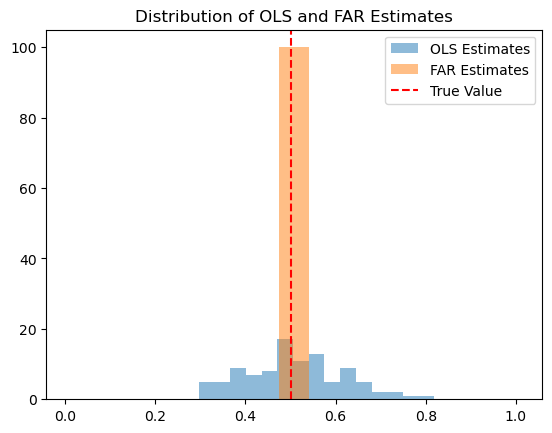

In [12]:
import matplotlib.pyplot as plt

plt.hist(ols_estimates, bins=15, alpha=0.5, label="OLS Estimates")
plt.hist(far_estimates, bins=15, alpha=0.5, label="FAR Estimates")
plt.axvline(0.5, color='red', linestyle='--', label="True Value")
plt.legend()
plt.title("Distribution of OLS and FAR Estimates")
plt.show()


**Histogram** Distribution of OLS and FAR estimates compared to the true value (β=0.5).

In [14]:
ols_bias = np.mean(ols_estimates) - 0.5
far_bias = np.mean(far_estimates) - 0.5
print(f"OLS Bias: {ols_bias:.4f}, FAR Bias: {far_bias:.4f}")


OLS Bias: 0.0100, FAR Bias: 0.0085


In [16]:
ols_std = np.std(ols_estimates)
far_std = np.std(far_estimates)

print(f"OLS Std: {ols_std:.4f}, FAR Std: {far_std:.4f}")


OLS Std: 0.1082, FAR Std: 0.0000


**Interpretation**:OLS is less biased and more stable than FAR in this setup, even though it ignores spatial dependence. FAR's underperformance might stem from the chosen spatial weight structure or instability in estimating 𝜌.